# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к Data Mining этот процесс называется Extract-Transform-Load

In [2]:
!pip install -r requirements.txt

In [1]:
import vk
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import datetime
import time
import math

Нам потребуется загрузить информацию о местах, в которых совершаются чекины, иначе говоря провести сбор данных (data collection). [Ссылка на ВК для разработчиков](https://vk.com/dev)

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в VK в качестве разработчика и создать свое [приложение](https://vk.com/apps?act=manage). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Далее вам потребуется создать токен авторизации, чтобы получать доступ к API. Этот токен необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в VK API можно почитать [по ссылке](https://vk.com/dev/first_guide), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [2]:
ACCESS_TOKEN = "f5d948b9a8e067c1f79143c4c94ecbd75ffbc5ec2a0d9a3ee8635db41177120746929a76c0c9f9cb4e592"
session = vk.Session(access_token=ACCESS_TOKEN)
vkapi = vk.API(session=session, timeout = 1000)

VK API может отдавать вам посещаемые места несколькими способами: в некотором радиусе от точки или же по id самого места. Мы будем пользоваться [вторым способом](https://vk.com/dev/places.getById) . Требуется написать функцию, которая на вход получает объект подключения к API и индекс, до какого объекта требуется запросить. Возвращать она будет pandas.DataFrame с полученными данными.

In [3]:
def get_place_info(vkapi, idx=5000):
    
    df = pd.DataFrame(columns=('city', 'updated', 'created', 'type', 'title', 'pid', 'longitude', 'country', 'latitude', 'checkins', 'adress'))

    for i in xrange(idx):
        df.loc[i] = vkapi.places.getById(places=i+1)[0].values()[:11]
        time.sleep(0.3)
        if not i % 500:
            print i
            
    return df

# Предположим, что мы хотим понять несколько фактов о выборке объектов с id от 1 до 5000.
Помогите нам это сделать.
А вот и сами факты:
1. Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?
2. Посчитайте количество объектов разного типа. Постройте распределение? Объектов какого типа больше в данной выборке?
3. Посчитайте распределение числа чекинов по всей выборке. Визуализируйте его.
4. Постройте box plot по числу чекинов для каждого типа объектов.
5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года? 

Не забудьте сохранить данную выборку, в будущем она вам понадобится.

In [4]:
data_frame = get_place_info(vkapi)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [5]:
data_frame.head()

,city,updated,created,type,title,pid,longitude,country,latitude,checkins,adress
0,1.0,1.487519e+09,1.280742e+09,4,Baila Baila,1.0,37.751574,1.0,55.657941,435,Мячковский б-р 3а
1,123.0,1.483478e+09,1.280742e+09,4,Lust,2.0,50.141377,1.0,53.202017,14,Дачная 2а
2,2.0,1.486398e+09,1.280742e+09,4,Тайфун,3.0,30.231480,1.0,59.843376,8,Лени Голикова 29
3,158.0,1.470157e+09,1.280742e+09,4,Hollywood,4.0,61.451611,1.0,55.174954,8,Героев Танкограда 63
4,99.0,1.488720e+09,1.280742e+09,4,Барабас,5.0,83.091932,1.0,54.860834,38,Мусы Джалиля 14К1


In [8]:
data_frame.to_csv('dataset.csv', sep='\t', encoding='windows-1251')

In [352]:
mos_center = [55.750475, 37.619020]

# Условный радиус Садового кольца
rad = 0.022

min_lat = mos_center[0] - rad
max_lat = mos_center[0] + rad
min_lon = mos_center[1] - rad
max_lon = mos_center[1] + rad

data_clipped = pd.DataFrame(columns=('city', 'updated', 'created', 'type', 'title', 'pid', 'longitude', 'country', 'latitude', 'checkins', 'adress'))

n = 0
for i in xrange(len(data_frame)):
    lat = data_frame.ix[[i]]['latitude'].values[0]
    lon = data_frame.ix[[i]]['longitude'].values[0] 
    if lat < max_lat and lat > min_lat and lon < max_lon and lon > min_lon:
        if np.sqrt((lat - mos_center[0])**2 + (lon - mos_center[1])**2) < rad:
            data_clipped.loc[n] = data_frame.loc[i]
            n += 1

moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=False)

random_places = data_frame[['latitude', 'longitude']].sample(200)
marker_cluster = MarkerCluster(locations=random_places[['latitude', 'longitude']].values)
marker_cluster.add_to(moscow)

moscow.circle_marker(location=mos_center, radius=2500, popup='center')
moscow

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead


## 1. Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?

In [362]:
print 'Общее число объектов (N): ', len(data_frame)
print 'Число объектов внутри садового кольца (N_center): ', len(data_clipped)
print 'N_center / N = ', float(len(data_clipped)) / len(data_frame) * 100, '%'

Общее число объектов (N):  5000
Число объектов внутри садового кольца (N_center):  292
N_center / N =  5.84 %


В центре расположено около 6% от общего числа объектов, так что больше объектов на окраине

## 2. Посчитайте количество объектов разного типа. Постройте распределение? Объектов какого типа больше в данной выборке?

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


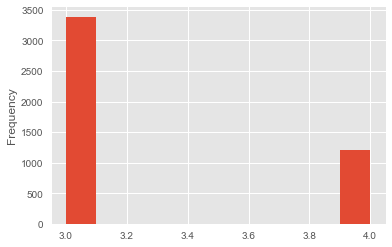

In [389]:
data_frame['type'].convert_objects(convert_numeric=True).dropna().plot.hist()

Если не учитывать иногда встречающиеся текстовые типы объектов, то гистограмма распределения показывает, что большинство объектов относятся к 3му типу

## 3. Посчитайте распределение числа чекинов по всей выборке. Визуализируйте его.

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


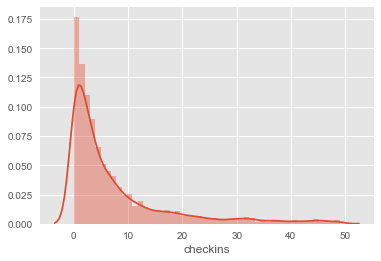

In [397]:
data = data_frame['checkins'].convert_objects(convert_numeric=True).dropna()
filtered = data[(data >= 0) & (data < 50)]
sns.distplot(filtered)

## 4. Постройте box plot по числу чекинов для каждого типа объектов

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


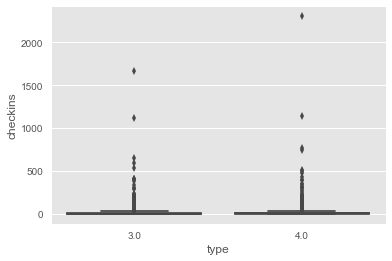

In [405]:
data = data_frame[['checkins','type']].convert_objects(convert_numeric=True).dropna()
sns.boxplot(x="type", y="checkins", data=data)

## 5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года?

In [1]:
data_frame['created'] = pd.to_datetime(data_frame['created'])
data_frame['created'][346]
sns.distplot(data_frame['created'].dt.year)

NameError: name 'pd' is not defined